In [4]:
import opensim as osim
import numpy as np
import hyperobjects as ho
import common
from opensim import Vec3
import matplotlib.pyplot as plt

In [106]:
np.random.seed(42)

model = osim.Model()
ground: osim.Ground = model.getGround()

body1 = osim.Body("body1", 1.0, osim.Vec3(0), osim.Inertia(0))
body2 = osim.Body("body2", 1.0, osim.Vec3(0), osim.Inertia(0))
body3 = osim.Body("body3", 1.0, osim.Vec3(0), osim.Inertia(0))

# Joints are described such that their rotation/translation axes form the identity in the parent frame.
joint1 = osim.BallJoint("joint1", ground, Vec3(0), Vec3(0), body1, Vec3(0,0.5,0), Vec3(0))
joint2 = osim.BallJoint("joint2", body1, Vec3(0, -0.5, 0), Vec3(0), body2, Vec3(0,0.3,0), Vec3(0))

# Only translational joint
off_x = osim.Body("joint3_x_child", 1.0, osim.Vec3(0), osim.Inertia(0))
off_y = osim.Body("joint3_y_child", 1.0, osim.Vec3(0), osim.Inertia(0))
joint3 = osim.SliderJoint("joint3_x", body2, Vec3(0, -0.5, 0), Vec3(0), off_x, Vec3(0), Vec3(0))
joint3_y = osim.SliderJoint("joint3_y", off_x, Vec3(0), Vec3(0, 0, osim.SimTK_PI/2), off_y, Vec3(0), Vec3(0))
joint3_z = osim.SliderJoint("joint3_z", off_y, Vec3(0), Vec3(0, -osim.SimTK_PI/2, 0), body3, Vec3(0,0.06,0), Vec3(0))

# Cable spanning one rotational joint only
C1 = osim.PathActuator()
C1_body_origin = ground
C1_body_insertion = body1
C1_O = np.random.uniform(size=3)
C1_I = np.random.uniform(size=3)
C1.addNewPathPoint("C1_O", C1_body_origin, Vec3(*C1_O))
C1.addNewPathPoint("C1_I", C1_body_insertion, Vec3(*C1_I))

# Cable spanning two rotational joints
C2 = osim.PathActuator()
C2_body_origin = ground
C2_body_insertion = body2
C2_O = np.random.uniform(size=3)
C2_I = np.random.uniform(size=3)
C2.addNewPathPoint("C2_O", C2_body_origin, Vec3(*C2_O))
C2.addNewPathPoint("C2_I", C2_body_insertion, Vec3(*C2_I))

# Cable spanning one translation joint only
C3 = osim.PathActuator()
C3_body_origin = body2
C3_body_insertion = body3
C3_O = np.random.uniform(size=3)
C3_I = np.random.uniform(size=3)
C3.addNewPathPoint("C3_O", C3_body_origin, Vec3(*C3_O))
C3.addNewPathPoint("C3_I", C3_body_insertion, Vec3(*C3_I))

# Cable spanning one translation joint and one rotational joint
C4 = osim.PathActuator()
C4_body_origin = body1
C4_body_insertion = body3
C4_O = np.random.uniform(size=3)
C4_I = np.random.uniform(size=3)
C4.addNewPathPoint("C4_O", C4_body_origin, Vec3(*C4_O))
C4.addNewPathPoint("C4_I", C4_body_insertion, Vec3(*C4_I))

model.addBody(body1)
model.addBody(body2)
model.addBody(body3)
model.addBody(off_x)
model.addBody(off_y)

model.addJoint(joint1)
model.addJoint(joint2)
model.addJoint(joint3)
model.addJoint(joint3_y)
model.addJoint(joint3_z)

model.addForce(C1)
model.addForce(C2)
model.addForce(C3)
model.addForce(C4)
# model.addJoint(joint3)
Q_null = model.initSystem()
model.realizePosition(Q_null)
model.equilibrateMuscles(Q_null)

Q_val = np.random.uniform(-np.pi, np.pi, size=(500, 9))
all_states = [osim.State(Q_null) for _ in Q_val]

for state in all_states:
    model.realizePosition(state)
    model.equilibrateMuscles(state)

for k, state in enumerate(all_states):
    for i, c in enumerate(model.getCoordinateSet()):
        c.setValue(state, Q_val[k, i])


In [152]:
coordinates = model.getCoordinateSet()

muscle = C4

lengths = []
norms_proj = []
norms = []
for Q in all_states:
    Jl = common.station_jacobian(model, Q, Vec3(*[1,1,0]), body3)
    # Jw = common.frame_jacobian(model, Q, body3)
    # print(Jl.round(2))
    # print(Jw.round(2))
    J = Jl
    # print(Jl.round(2))
    # print(Jl.round(2))
    # print(J)
    # break
    imJt = ho.AffineSpace(J.T)
    proj = imJt.orthogonal_projection_matrix
    # print(J.round(2))
    # break
    la = common.lever_arm_matrix(Q, [muscle], coordinates).ravel()
    O_in_Jt = proj @ la
    norms_proj.append(np.linalg.norm(O_in_Jt))
    l = muscle.getLength(Q)
    lengths.append(l)

    norms.append(np.linalg.norm(la))
    
norms = np.array(norms)
norms_proj = np.array(norms_proj)
lengths = np.array(lengths)

In [153]:
print(norms.tolist())
print(norms_proj.tolist())

[1.4728404296008597, 1.4785493657842275, 1.0261109917786233, 1.1796008113511773, 1.2576414559434361, 1.073696734642703, 1.4474795407665935, 1.107288250416701, 1.4740502372625461, 1.027457406306207, 1.076127089248502, 1.2621026043883872, 1.4092544831039417, 1.459642425723401, 1.3768092457331527, 1.4279356521436466, 1.2672563742360792, 1.310296449310389, 1.368901160898294, 1.4144908944102166, 1.3228605618155838, 1.1925652375889515, 1.3234462951600152, 1.137270909941851, 1.1042953165444493, 1.041422387419436, 1.1582416667773887, 1.4383494507173629, 1.4074604603404617, 1.3564375077675999, 1.2611923433221033, 1.4714572132593793, 1.4226170389561537, 1.4786732076933633, 1.4742350828921118, 1.4288537644680908, 1.467641438223266, 1.2837264001285167, 1.344699503631087, 1.341482955327727, 1.0365664022966512, 1.2539383156446415, 1.4769274353953408, 1.450185906217502, 1.4087014000770859, 1.3485697656235007, 1.2162408464844123, 1.345086958339124, 1.2427764470555256, 1.345973576801995, 1.113495243278

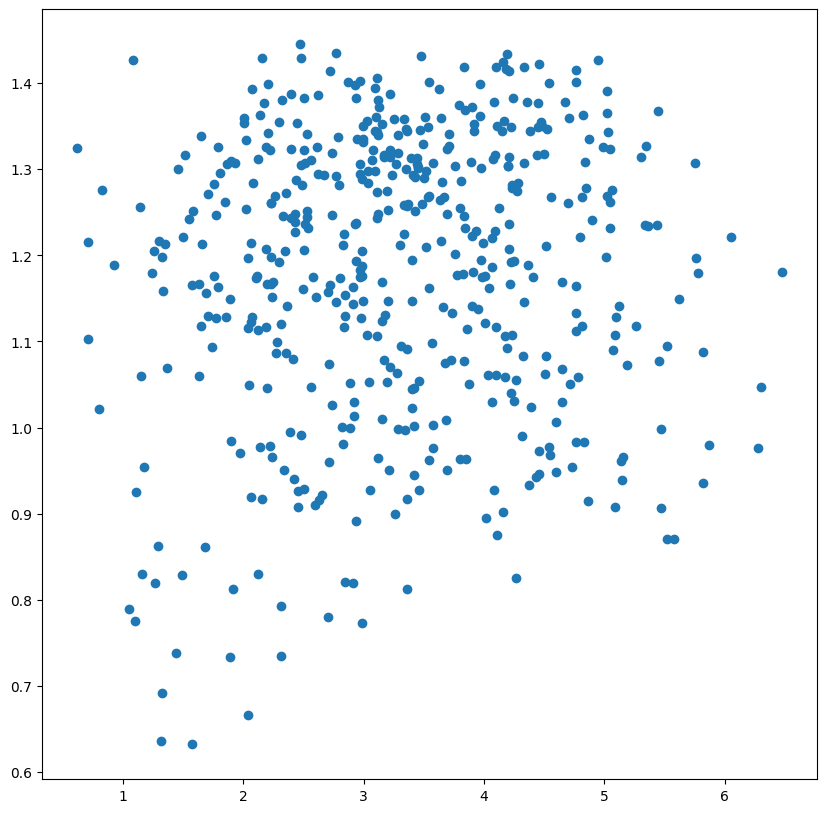

In [154]:
%matplotlib inline


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)

X = list(range(len(all_states)))

# ax.scatter(lengths, (norms)/lengths)
# ax.scatter(lengths, lengths/(norms/norms_proj))
# ax.scatter(lengths, lengths)
# ax.scatter(lengths, (norms_proj))
ax.scatter(lengths, (norms_proj))
# ax.scatter(lengths, (norms/norms_proj) / lengths)
# ax.scatter(lengths, norms / norms_proj)
# ax.scatter(lengths, norms / 0.57)

In [46]:
norms_proj / norms

array([0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735027,
       0.57735027, 0.57735027, 0.57735027, 0.57735027, 0.57735

In [13]:
X

array([0.82376066, 1.26724642, 1.28826076, 1.32385044, 1.3247756 ,
       1.33528397, 1.44075297, 1.57005908, 1.73963867, 1.75886574,
       1.84395117, 1.85789743, 2.00194359, 2.04768356, 2.06651469,
       2.1515341 , 2.18518338, 2.20642301, 2.23015071, 2.23232671,
       2.24111448, 2.27691674, 2.4477996 , 2.47013137, 2.50305184,
       2.56498333, 2.62157873, 2.66649023, 2.70068298, 2.71023823,
       2.71674266, 2.74008234, 2.77351973, 2.81924642, 2.84227026,
       2.84440254, 2.9326524 , 2.96766919, 2.96893834, 2.97426239,
       2.990792  , 3.03074122, 3.04247913, 3.10862348, 3.11422015,
       3.11613562, 3.12092393, 3.1995357 , 3.20118454, 3.28359272,
       3.31404668, 3.35682708, 3.3614053 , 3.40016821, 3.41965291,
       3.45531239, 3.47840557, 3.52166246, 3.54282673, 3.5780777 ,
       3.66710141, 3.69377965, 3.71334717, 3.72399947, 3.73139285,
       3.7612542 , 3.79856289, 3.80693876, 3.83665252, 3.85041857,
       3.89722434, 3.90297226, 3.90963868, 3.9805554 , 3.99061